<a href="https://colab.research.google.com/github/yalexie1/Data-Science/blob/main/Unit4/Yale_XieU4proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part I: Introduction**

For my Unit 4 project, I will be comparing hierarchical and nonhierarchical models to determine the **changes in stock price** of four AI companies, those being **NVIDIA, AMD, Google, and Microsoft**. Specifically, I want to see if there are any **connections** between these changes and interpret the data to understand what it means for these companies.

With that out of the way, **let's get into it**.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# **Part II: Data**

Similarly to my Unit 3 project, I will use data from NASDAQ's website to solve this problem. I imported **three months** (one quarter) of **open and close price data** for the four companies (**NVIDIA, AMD, GOOGL, MSFT**) and used Google Sheets to organize the data into a useful spreadsheet.

Then, I found the difference between the close and open prices for each date to find the **change in stock price** (amount gained or lost over that day).Finally, I downloaded the spreadsheet as a **csv** (comma-separated values) file before uploading it to my GitHub, where I could access the raw data in Google Colab using Pandas.

In [2]:
url_stock_data = 'https://raw.githubusercontent.com/xeqoir/Data-Science/refs/heads/main/Unit4/AI%20Company%20Stock%20Data%20-%20Sheet1.csv'
stock_data = pd.read_csv(url_stock_data)

stock_data

,Date,Company,Close,Open,Difference
0,10/31/2024,NVIDIA,132.76,137.60,-4.84
1,10/30/2024,NVIDIA,139.34,139.54,-0.20
2,10/29/2024,NVIDIA,141.25,140.29,0.97
3,10/28/2024,NVIDIA,140.52,143.00,-2.48
4,10/25/2024,NVIDIA,141.54,140.93,0.61
...,...,...,...,...,...
255,08/07/2024,MSFT,398.43,408.64,-10.21
256,08/06/2024,MSFT,399.61,400.00,-0.39
257,08/05/2024,MSFT,395.15,389.17,5.98
258,08/02/2024,MSFT,408.49,412.49,-4.00


The above Pandas DataFrame above shows stock data from the past quarter. The important column is the **last one**, which contains the change in stock price.

(array([ 2.,  8., 17., 42., 62., 84., 34.,  8.,  2.,  1.]),
 array([-12.46 ,  -9.948,  -7.436,  -4.924,  -2.412,   0.1  ,   2.612,
          5.124,   7.636,  10.148,  12.66 ]),
 <BarContainer object of 10 artists>)

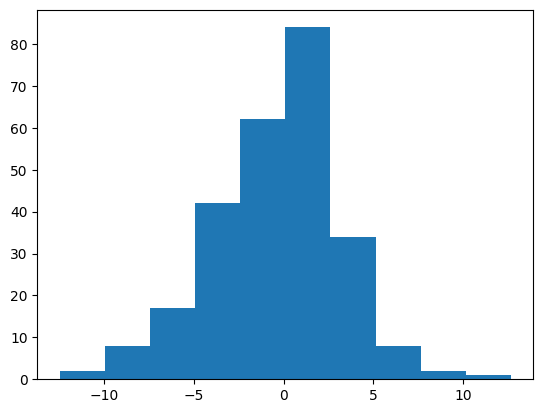

In [3]:
plt.hist(stock_data['Difference'])

In [4]:
print(stock_data['Difference'].mean())
print(stock_data['Difference'].median())

-0.3708461538461538
0.075


The above histogram provides a **discrete visual** of our stock data. As can be seen, there is a **negative skew**, which should be taken into account when creating continuous distributions of our data.

In [5]:
company_encode = pd.Categorical(stock_data['Company'])
company_index = company_encode.codes
company_coords = {"companies": company_encode.categories}

print(company_encode)
print(company_index)
print(company_coords)

['NVIDIA', 'NVIDIA', 'NVIDIA', 'NVIDIA', 'NVIDIA', ..., 'MSFT', 'MSFT', 'MSFT', 'MSFT', 'MSFT']
Length: 260
Categories (4, object): ['AMD', 'GOOGL', 'MSFT', 'NVIDIA']
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2]
{'companies': Index(['AMD', 'GOOGL', 'MSFT', 'NVIDIA'], dtype='object')}


# **Part III: Nonhierarchical Models**

Now that we have properly created our dataset, we are ready to begin creating some models. I'll start with **nonhierarchical** models, which assume **independence** among groups and therefore do **not** have any shared hyperpriors.

## Initial nonhierarchical model

In [ ]:
with pm.Model(coords = company_coords) as stock_model_nh:

  # Regular priors
  μ = pm.Normal('μ', mu = 0, sigma = 10, dims = "companies")
  σ = pm.HalfNormal('σ', sigma = 10, dims = "companies")
  ν = pm.Exponential('ν', lam = 0.5, dims = "companies")

  # Likelihood
  y = pm.StudentT('y', mu = μ[company_index], sigma = σ[company_index], nu = ν[company_index],
                  observed = stock_data["Difference"])

  idata_stock_nh = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_stock_nh, model = stock_model_nh, extend_inferencedata=True)

(-10.0, 10.0)

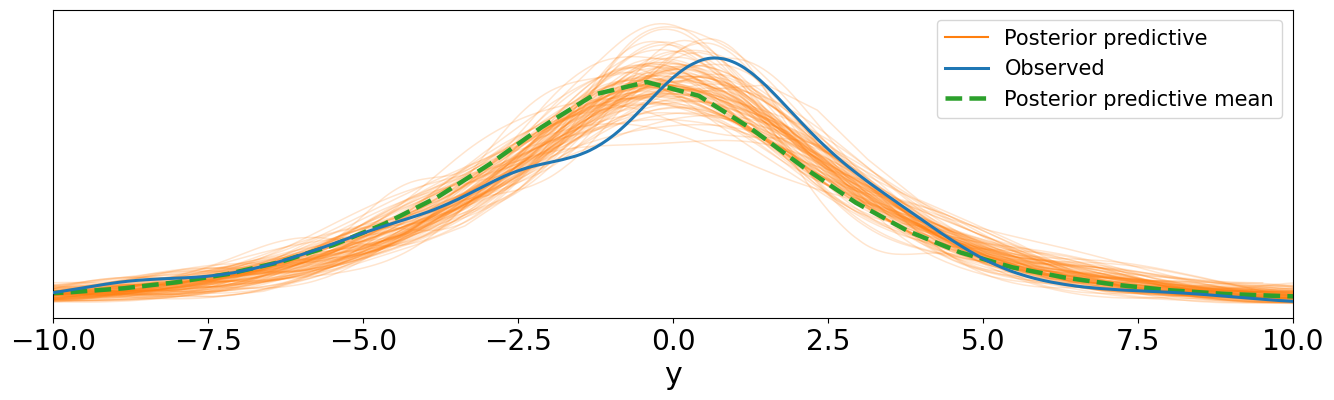

In [8]:
ax = az.plot_ppc(idata_stock_nh, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-10, 10)

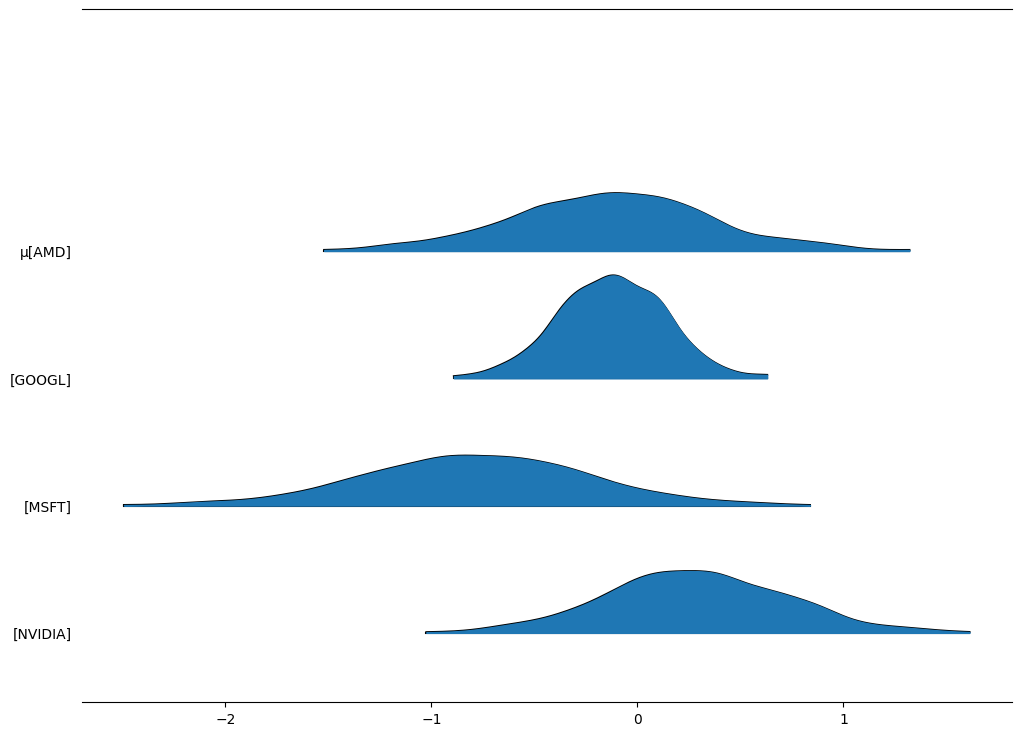

In [9]:
axes = az.plot_forest(idata_stock_nh, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

My initial nonhierarchical model is **not great** (posterior predictive to observed check), and the primary reason for this is because it didn't take into account the **negative skew** we found in the histogram earlier (StudentT does not have skew). The reason I made a model without skew when I know it should have skew is because I just wanted a **baseline** model to improve off of, rather than developing a more complex skewed model right off the bat.

Now, let's create a better model that takes into our negatives skew.

P.S. If you're wondering how I chose my priors for this model, I basically picked the most generic distributions for them (Normal for mean, HalfNormal for standard deviation, and Exponential for normality). I decided on relatively high variation for mean and standard deviation (hence, "sigma = 10") because I wasn't too sure what it should look like and I chose a low normality (lambda = 0.5) because the observed was definitely not completely normal.

## Second nonhierarchical model


In [ ]:
with pm.Model(coords = company_coords) as stock_model_nh2:

  # Regular priors
  μ = pm.Normal('μ', mu = 0, sigma = 10, dims = "companies")
  σ = pm.HalfCauchy('σ', beta = 10, dims = "companies")
  α = pm.Uniform('α', upper = 2, lower = 1, dims = "companies")
  β = pm.Uniform('β', upper = 4, lower = 3, dims = "companies")

  # Likelihood
  y = pm.SkewStudentT('y', mu = μ[company_index], sigma = σ[company_index],
                      a = α[company_index], b = β[company_index],
                      observed = stock_data["Difference"])

  idata_stock_nh2 = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_stock_nh2, model = stock_model_nh2, extend_inferencedata=True)

(-10.0, 10.0)

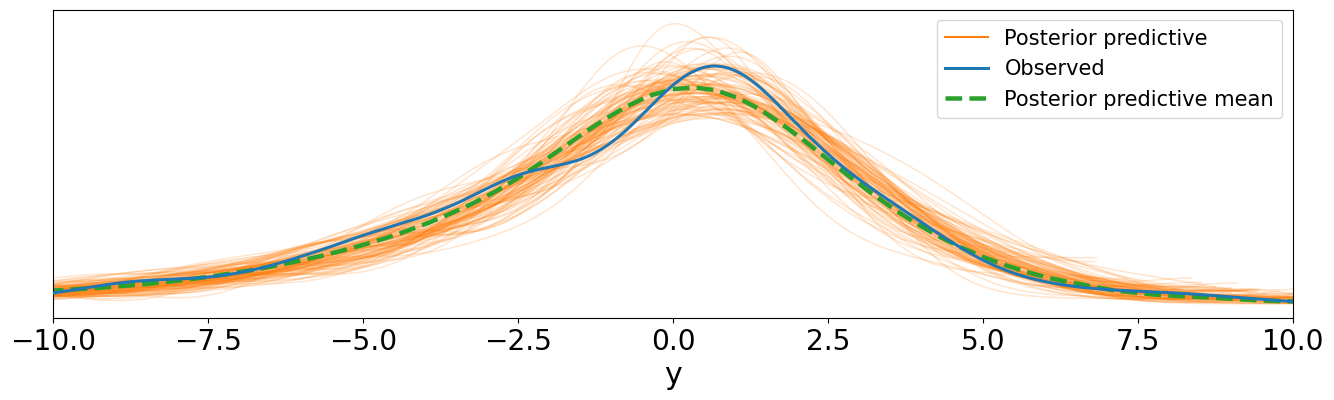

In [12]:
ax = az.plot_ppc(idata_stock_nh2, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-10, 10)

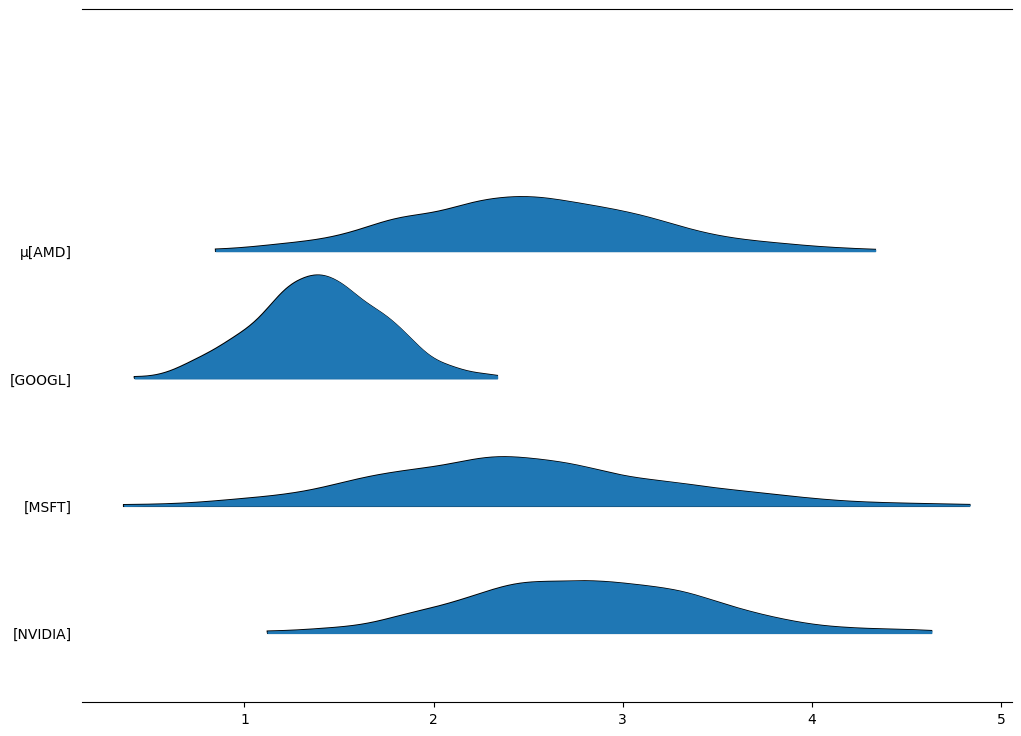

In [13]:
axes = az.plot_forest(idata_stock_nh2, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

This model is **better**, as it actually accounts for the **negative skew** (SkewStudentT takes in two variables a and b to describe skew). The posterior predictive to observed check shows that they **match up very well at the tails** but slightly **over and under shoot both modes**. You might've noticed I changed my standard deviation prior to a **HalfCauchy** distribution (from HalfNormal). This is because I want the possiblity of **higher standard deviations** due to my inexperience and lack of understanding for the wider forces influencing the data.

I chose **uniform distributions** for my a and b priors because I needed to make sure that **b is always greater than a** (for the negative skew). I picked the numbers essentially by **chance**, starting with the most **basic** values possible (1, 2, 3, and 4).

Let's **modify** the a and b priors a little bit and see if we can get something better.

## Third nonhierarchical model

In [ ]:
with pm.Model(coords = company_coords) as stock_model_nh3:

  # Regular priors
  μ = pm.Normal('μ', mu = 0, sigma = 10, dims = "companies")
  σ = pm.HalfCauchy('σ', beta = 10, dims = "companies")
  α = pm.Uniform('α', upper = 1, lower = 0.5, dims = "companies")
  β = pm.Uniform('β', upper = 2, lower = 1, dims = "companies")

  # Likelihood
  y = pm.SkewStudentT('y', mu = μ[company_index], sigma = σ[company_index],
                      a = α[company_index], b = β[company_index],
                      observed = stock_data["Difference"])

  idata_stock_nh3 = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_stock_nh3, model = stock_model_nh3, extend_inferencedata=True)

(-10.0, 10.0)

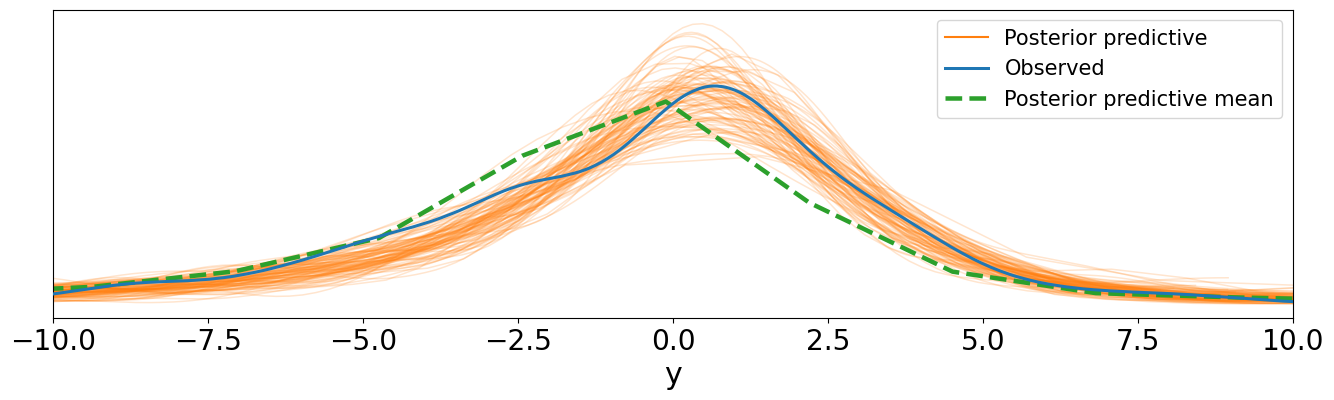

In [16]:
ax = az.plot_ppc(idata_stock_nh3, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-10, 10)

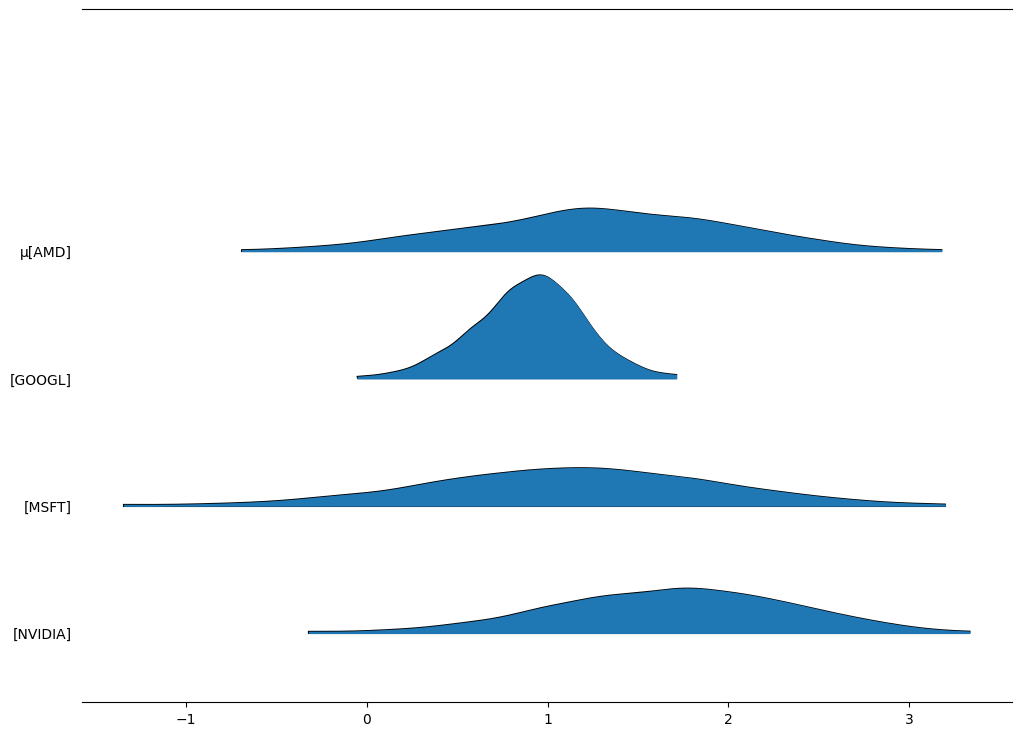

In [17]:
axes = az.plot_forest(idata_stock_nh3, kind="ridgeplot",
                      var_names='μ',
                      combined=True, figsize=(12, 9), hdi_prob=0.997)

This model is roughly the **same** as the previous by doing the poster predictive to observed check. I'd say it's maybe **slightly better** at modelling the modes than the previous SkewStudentT model (don't look at the mean, just the individual samplings).

All I did different for this one from the previous is **decreasing** the values of a and b (from 1-2 to 0.5-1 and from 3-4 to 1-2).

I will call this model my best nonhierarchical one for now.

# Part IV: Hierarchical Models

I think I've done the best I can modelling the data with nonhierarchical models. Now, let's try doing the same task but with **hierarchical** models, which have shared **hyperpriors** and assume some level of **dependence** between groups.

## First hierarchical model

In [ ]:
with pm.Model(coords = company_coords) as stock_model_h:

  # Hyperpriors
  μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 5)
  σ_mu = pm.HalfNormal('σ_mu', sigma = 3)
  ν_mu = pm.Exponential('ν_mu', lam = 0.5)

  # Regular priors
  μ = pm.StudentT('μ', mu = μ_mu, sigma = σ_mu, nu = ν_mu, dims = "companies")
  σ = pm.HalfNormal('σ', sigma = 10, dims = "companies")
  ν = pm.Exponential('ν', lam = 0.5, dims = "companies")

  # Likelihood
  y = pm.StudentT('y', mu = μ[company_index], sigma = σ[company_index], nu = ν[company_index],
                  observed = stock_data["Difference"])

  idata_stock_h = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_stock_h, model = stock_model_h, extend_inferencedata=True)

(-10.0, 10.0)

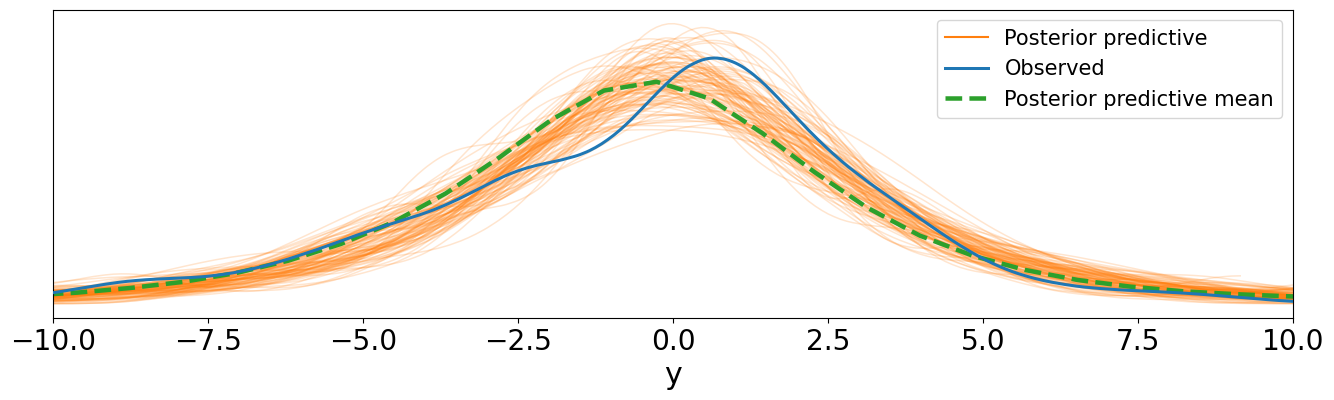

In [20]:
ax = az.plot_ppc(idata_stock_h, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-10, 10)

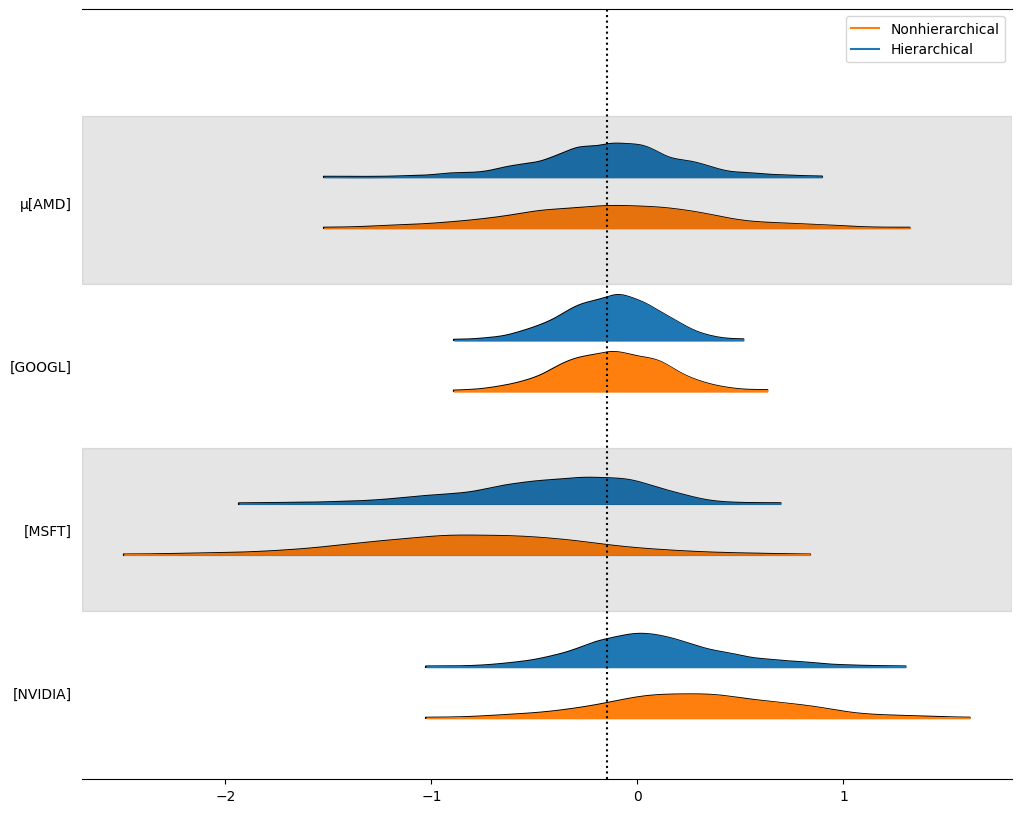

In [21]:
axes = az.plot_forest([idata_stock_h, idata_stock_nh], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

y_lims = axes[0].get_ylim()
axes[0].vlines(idata_stock_h.posterior['μ'].mean(), *y_lims, color="k", ls=":");

<xarray.Dataset> Size: 216B
Dimensions:    (companies: 4)
Coordinates:
  * companies  (companies) <U6 96B 'AMD' 'GOOGL' 'MSFT' 'NVIDIA'
Data variables:
    μ          (companies) float64 32B 1.002 1.004 1.005 1.005
    μ_mu       float64 8B 1.01
    ν          (companies) float64 32B 1.003 1.003 1.0 0.9999
    ν_mu       float64 8B 1.002
    σ          (companies) float64 32B 1.002 1.002 1.002 1.003
    σ_mu       float64 8B 1.006

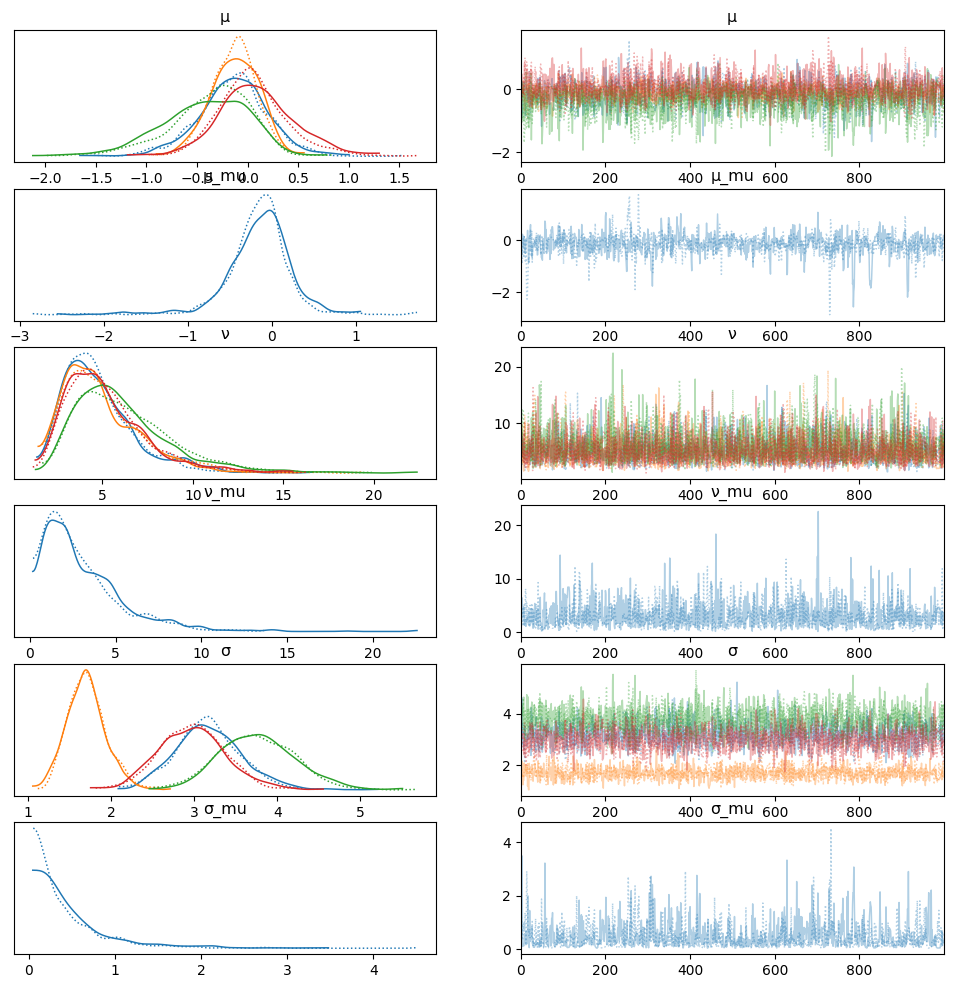

In [22]:
az.plot_trace(idata_stock_h)
az.rhat(idata_stock_h)

This model does **not** take into account the **negative skew** of our data, so it's definitely **not the best** we can do. The modes don't match up well and the rightward tail is not matched either. The R-hat values are alright since they are all **between 1 and 1.01**. The traces are also alright, since most of the **amplitudes match up**, though there are some significant **outliers** in σ_mu.

We can also see the **shrinkage** hierarchical models have when we compared the **ridgeplots** of the hierarchical and nonhierarchical models. Overall, this model is not great and I think we can do better with a **SkewStudentT** likelihood.

## **Second hierarchical model**

In [ ]:
with pm.Model(coords = company_coords) as stock_model_h2:

  # Hyperpriors
  μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 10)
  σ_mu = pm.HalfCauchy('σ_mu', beta = 10)
  α_mu = pm.Uniform('α_mu', upper = 1, lower = 0.5)
  β_mu = pm.Uniform('β_mu', upper = 2, lower = 1)

  σ_sigma = pm.HalfCauchy('σ_sigma', beta = 8)

  # Regular priors
  μ = pm.SkewStudentT('μ', mu = μ_mu, sigma = σ_mu, a = α_mu, b = β_mu, dims = "companies")
  σ = pm.HalfNormal('σ', sigma = σ_sigma, dims = "companies")


  # Likelihood
  y = pm.SkewStudentT('y', mu = μ[company_index], sigma = σ[company_index], a = α_mu, b = β_mu,
                  observed = stock_data["Difference"])

  idata_stock_h2 = pm.sample()

In [ ]:
pm.sample_posterior_predictive(idata_stock_h2, model = stock_model_h2, extend_inferencedata=True)

(-10.0, 10.0)

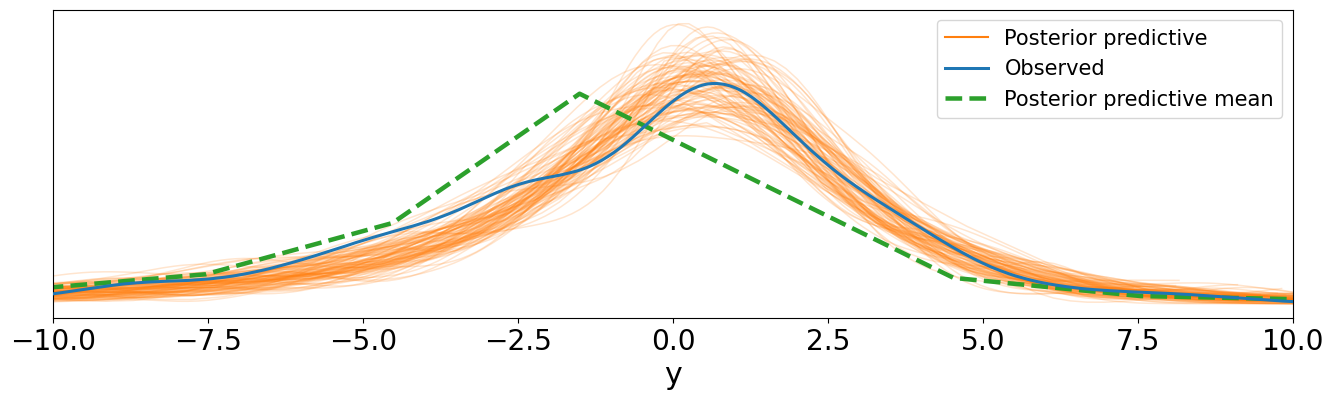

In [25]:
ax = az.plot_ppc(idata_stock_h2, num_pp_samples=100, figsize=(16, 4), colors=["C1", "C0", "C2"])
ax.set_xlim(-10, 10)

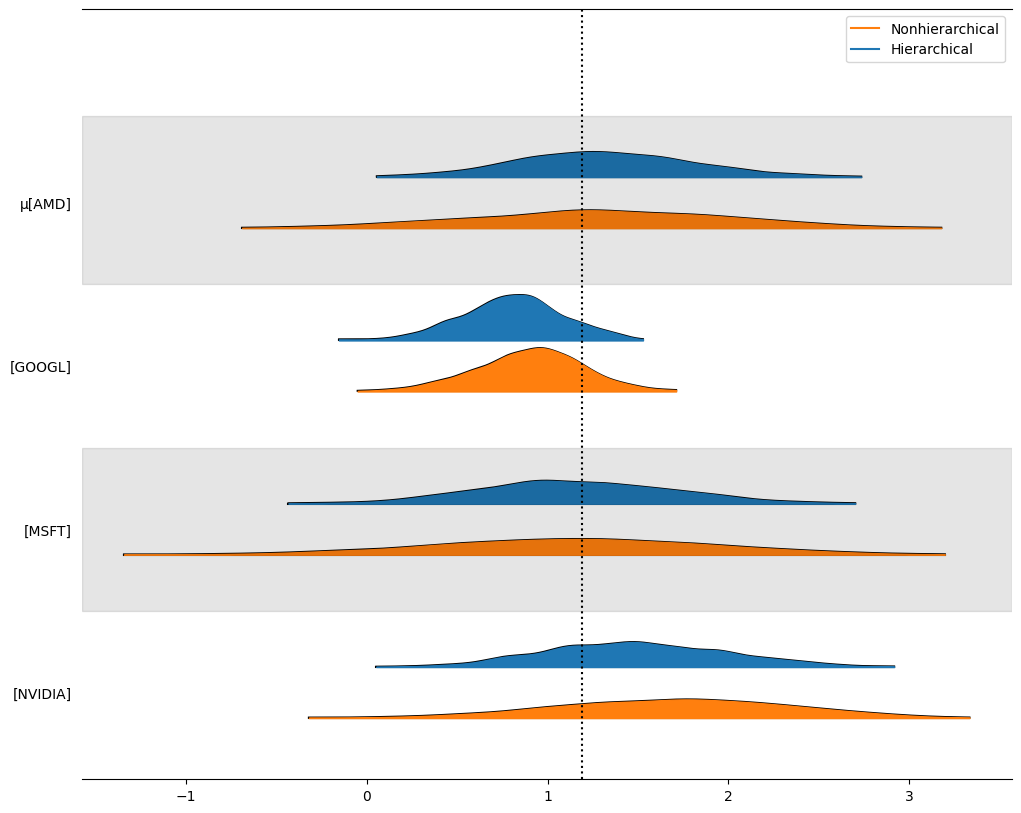

In [26]:
axes = az.plot_forest([idata_stock_h2, idata_stock_nh3], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_stock_h2.posterior['μ'].mean(), *y_lims, color="k", ls=":");

<xarray.Dataset> Size: 200B
Dimensions:    (companies: 4)
Coordinates:
  * companies  (companies) <U6 96B 'AMD' 'GOOGL' 'MSFT' 'NVIDIA'
Data variables:
    α_mu       float64 8B 1.001
    β_mu       float64 8B 1.005
    μ          (companies) float64 32B 1.008 1.001 1.004 1.009
    μ_mu       float64 8B 1.005
    σ          (companies) float64 32B 0.9999 1.0 1.001 1.003
    σ_mu       float64 8B 1.001
    σ_sigma    float64 8B 1.004

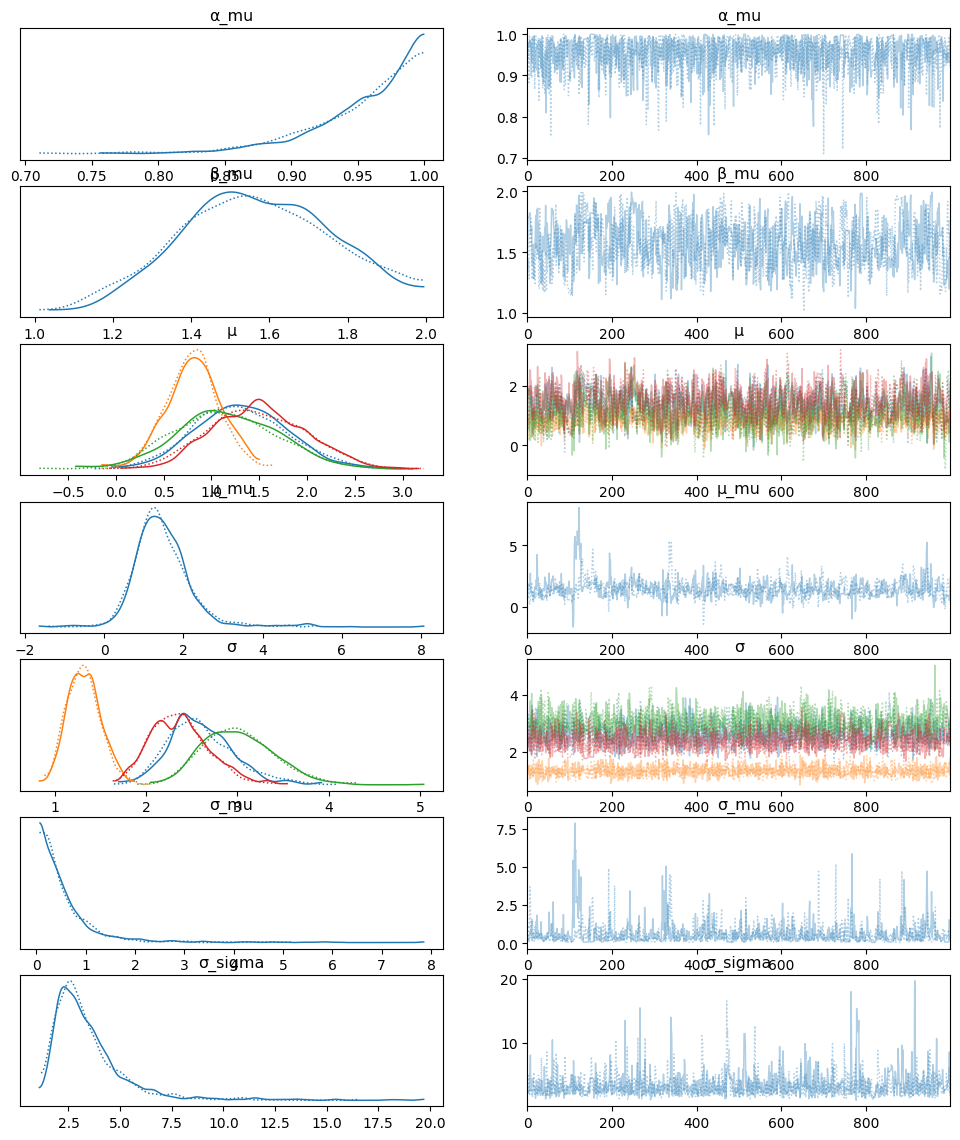

In [27]:
az.plot_trace(idata_stock_h2)
az.rhat(idata_stock_h2)

This model is **better** than the previous one because the **modes** match better. The R-hat values and traces are also still **good**. We can also still observe the shrinkage that the hierarchical model does by looking at the **ridgeplots** of the two models (this time I'm comparing **h2 and nh3**, models with **SkewStudentT** as its likelihood distribution). For now, I will call this model by best hierarchical model.

# Part V: Conclusions

Now that we've established the best nonhierarchical and hierarchical models, we can draw some conclusions from them. I will plot their respective ridgeplots again for convenience. Orange represents the nonhierarchical model and blue represents the hierarchical model.

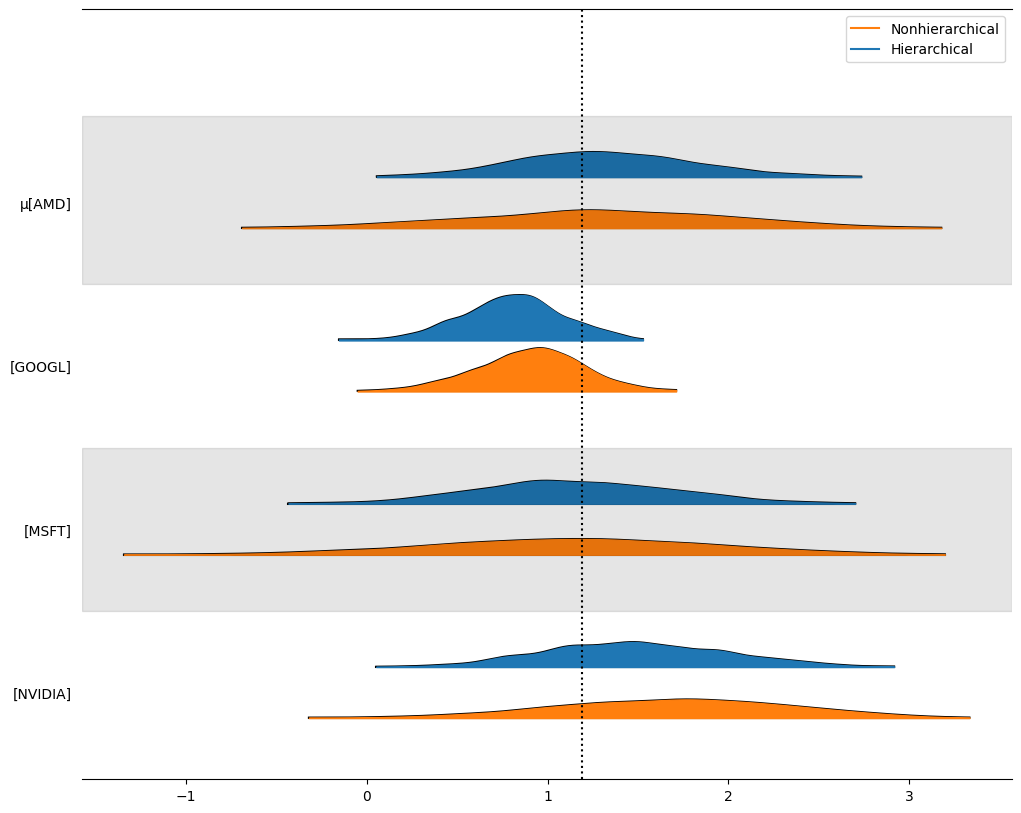

In [28]:
axes = az.plot_forest([idata_stock_h2, idata_stock_nh3], kind="ridgeplot",
                      model_names=['Hierarchical', 'Nonhierarchical'],
                      var_names='μ', combined=True, figsize=(12, 10),hdi_prob=0.997)

#plots overall mean of the hierarchical model; do not confuse with 0
y_lims = axes[0].get_ylim()
axes[0].vlines(idata_stock_h2.posterior['μ'].mean(), *y_lims, color="k", ls=":");

The first thing to note is that there seems to be a mean of around 1.1 to 1.2 with the hierarchical model usually being closer to that mean (I'll discuss the outlier in a moment). This means that these companies tend to make around $1.10 on average, which is wildly optimistic. Another thing to note is that three of the masses are very distributed while one is concentrated.

So what does this mean in the real world? Firstly, this confirms what people generally believe about Google - specifically that people typically don't have strong opinions about how Google will fare. This is shown by Google's high mass concentration (indicating stability), which also has a slightly lower mean than the rest (makes less).

Secondly, this model indicates that the AI technology market did very well this quarter, as the average change in stock price is given as around $1. Is this really what happened? Not really? This is something I'm not sure about - this period *is* successful (NVIDIA went up a lot, yay) but not successful to that mind-blowing amount. I think what can be drawn from this mean is simply that these companies generally did pretty well.

Thirdly, I'd say there is more of a connection betweeen NVIDIA, MSFT, and AMD than any of those with GOOGL because their (NVIDIA, MSFT, AMD) nonhierarchical models (which don't assume connections) are similar to each other while different from GOOGL's.

Finally, notice that the hierarchical model seems to reduce variation (at least at the modes), which means that it's probably better than the nonhierarchical model. That indicates that there *is* some sort of intrinsic relation or connection between these companies (which is that they're AI tech companies LOL).

Thanks for reading.